In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(qvalue))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(tidyverse))
options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
source('castom-igex_mr/Figures/Functions_plot_MR.R')

pval_FDR_rel <- 0.05
# load total result to annotate pathways and genes:
pathR <- fread('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/path_Reactome_pval_CAD_HARD_covCorr_filt.txt', h=T, stringsAsFactors = F, data.table = F)
pathGO <- fread('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/path_GO_pval_CAD_HARD_covCorr_filt.txt', h=T, stringsAsFactors = F, data.table = F)
#tscore <- fread('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb//CAD_GWAS_bin5e-2/UKBB/tscore_pval_CAD_HARD_covCorr.txt', h=T, stringsAsFactors = F, data.table = F)
pathR$new_id <- paste(pathR$path, pathR$tissue, sep = '_')
pathGO$new_id <- paste(pathGO$path, pathGO$tissue, sep = '_')



[1] "C"

In [2]:
### create table of phenotypes ###
comb_corr_file <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/enrichment_CADHARD_res/dist200000b_tscore_correlation_allTissues.txt"
corr_sign <- read.delim(comb_corr_file, h=T, stringsAsFactors = F, sep = '\t')

MR_pheno_subset <- read.table("castom-igex_mr/Figures/CAD/MR_subset_pheno.txt", h = F, stringsAsFactors = F, sep = '\t')$V1
corr_sign <- corr_sign[corr_sign$pheno_type %in% MR_pheno_subset,]

df_pheno_MR <- corr_sign %>% count(pheno_type) %>% mutate(pheno_id = NA)
for(i in 1:nrow(df_pheno_MR)){
        tmp <- corr_sign$pheno[corr_sign$pheno_type == df_pheno_MR$pheno_type[i]]
        df_pheno_MR$pheno_id[i] <- paste0(tmp, collapse = ',')
}
df_pheno_MR$covariates <- paste0(c("PC 1-10", "Sex"), collapse = ',')

cov_med <- read.table("CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/phenotypeDescription_covariateMatrix_withMedication.txt", h = T, stringsAsFactors = F, sep = '\t')
df_pheno_MR$covariates[df_pheno_MR$pheno_type %in% c("Blood_biochemistry", "Blood_count")] <- paste0(c("PC 1-10", "Sex", "Age",cov_med$pheno_id ), collapse = ',')

# save
write.table(df_pheno_MR, 'castom-igex_mr/Figures/CAD/count_pheno_tested.txt', quote = F, sep = '\t', col.names = T, row.names = F)

In [3]:
### explore results ####
tissue <- 'Artery_Coronary'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)

MRest <- read.delim(MRRes_IVW_file, h=T, stringsAsFactors = F)
MRest[grepl('Cheese',MRest$names_field),]

,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
23,32,-226.3795,74.4998,-372.3964,-80.3626,0.002376333,58.8908,0.001819559,Cheese intake (1408),1408,Diet,0.0143512


[1] 19


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
8,266,0.3964511,0.09955958,0.2013179,0.5915843,6.832377e-05,397.5817,2.379253e-07,C-reactive protein (30710),30710,Blood_biochemistry,0.0008781316


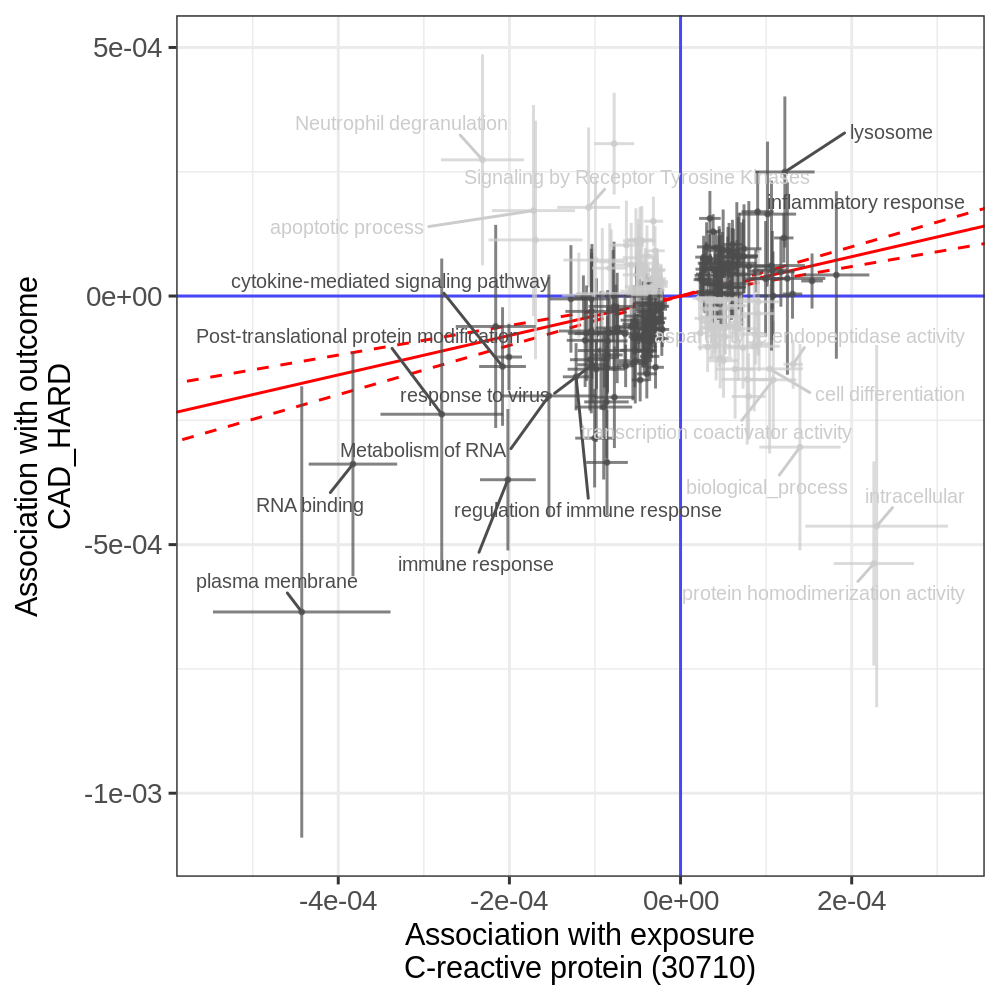

In [4]:
###############################################
### AVO pathways: CRP exposure, CAD outcome ###
###############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Adipose_Visceral_Omentum'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
MRRes_Egger_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_Mendelian_randomization_Egger_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/AVO_perc0.3_'
name_exposure <- '30710'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tot_path'
n_pl <- 40


### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

# save
write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')

res$MR[res$MR$pheno == name_exposure, ]


[1] 15


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
6,266,151.0088,54.48892,44.21249,257.8051,0.005582141,397.2168,2.534895e-07,C-reactive protein (30710),30710,Blood_biochemistry,0.03837722


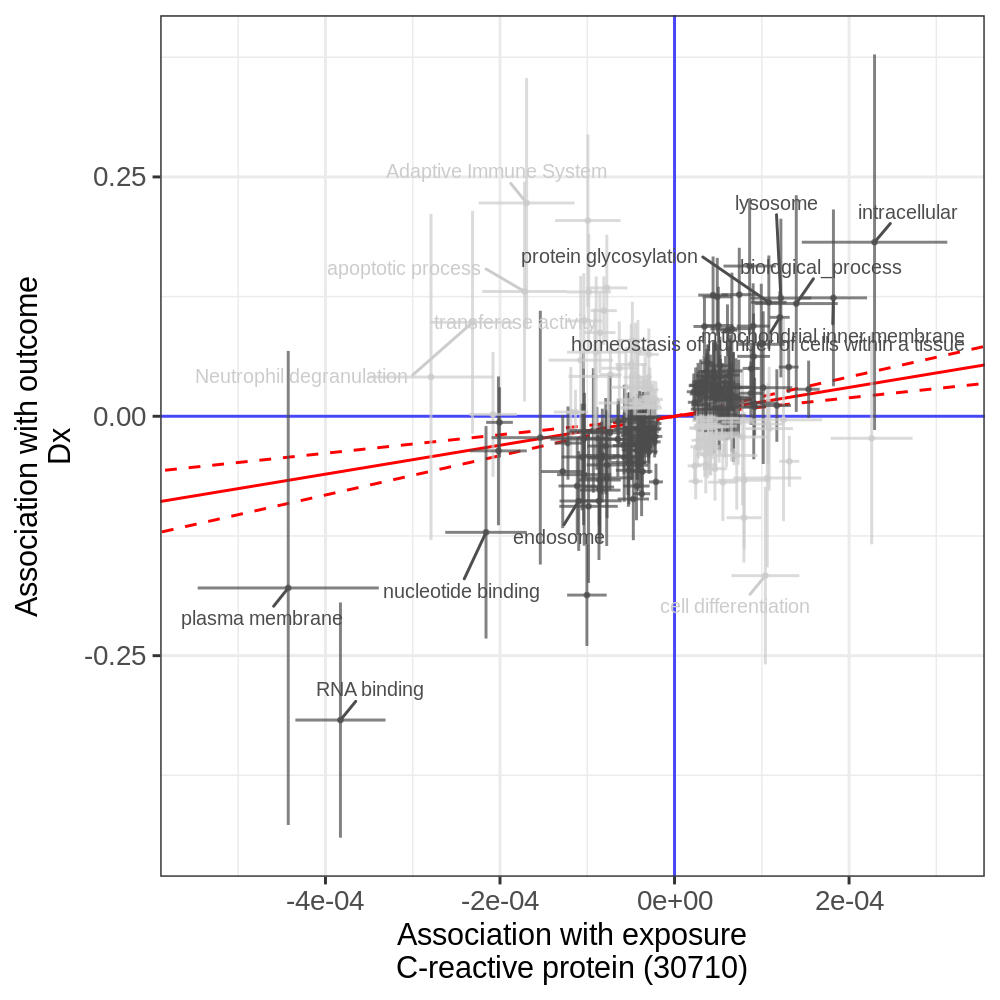

In [5]:
###############################################
### AVO pathways: CRP exposure, CAD outcome ###
################# CARDIoGRAM ##################
###############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Adipose_Visceral_Omentum'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_AVO_perc0.3_'
name_exposure <- '30710'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tot_path'
n_pl <- 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name


### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

#tab_note <- cbind(tmp[, ], new)
new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]



[1] 12


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
4,171,0.1724405,0.0787324,0.0181278,0.3267532,0.02850903,315.146,9.108031e-11,C-reactive protein (30710),30710,Blood_biochemistry,0.06253593


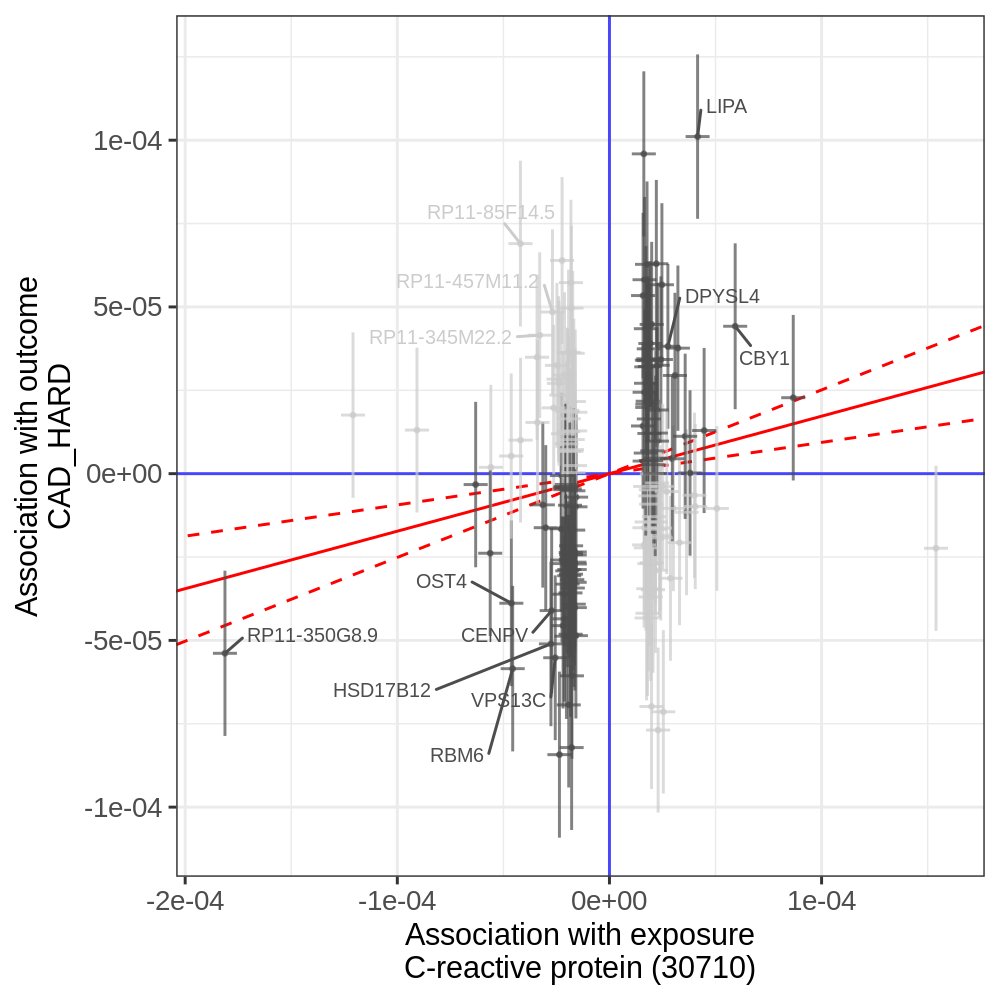

In [6]:
#############################################
### AVO tscore: CRP exposure, CAD outcome ###
#############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Adipose_Visceral_Omentum'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%s/correlation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/AVO_dist200000b_'
name_exposure <- '30710'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tscore'
n_pl <- 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome


write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]


[1] 14


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
7,167,95.04851,40.79633,15.08917,175.0079,0.01981514,289.3773,9.907588e-09,C-reactive protein (30710),30710,Blood_biochemistry,0.03396881


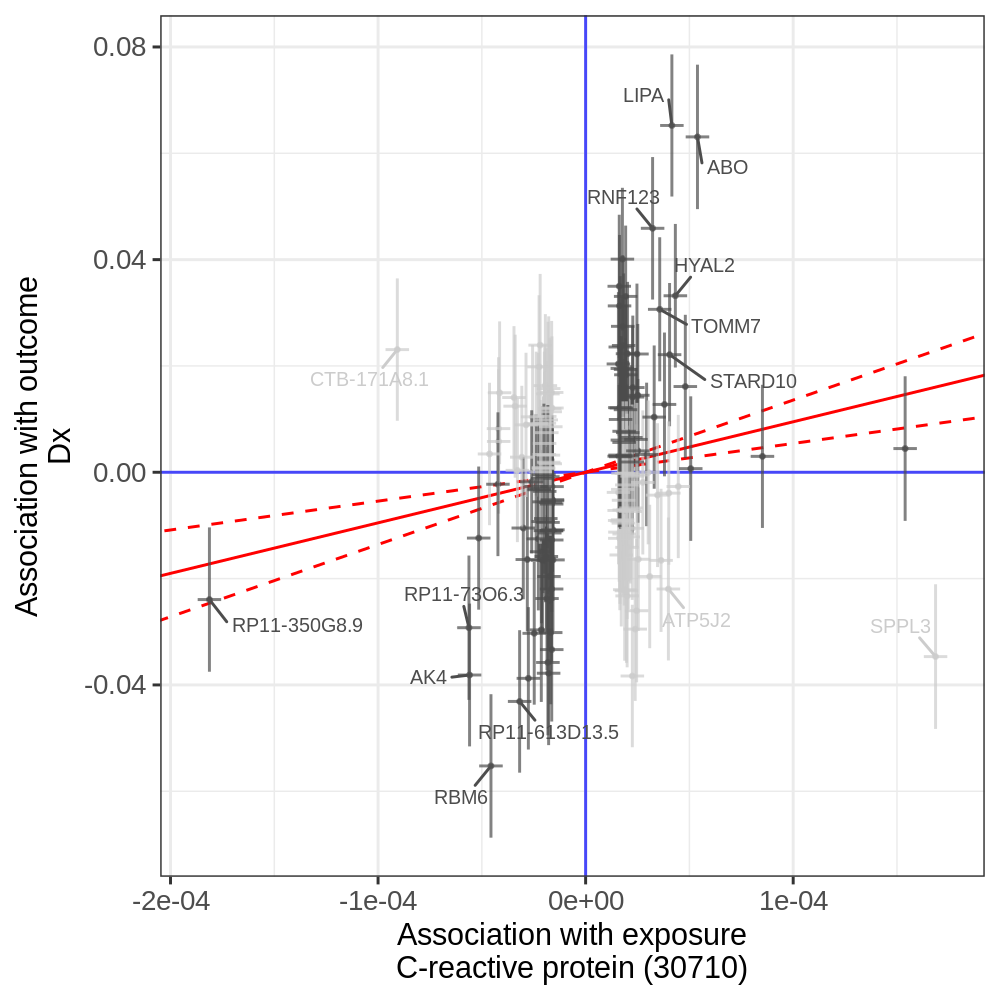

In [7]:
#############################################
### AVO tscore: CRP exposure, CAD outcome ###
############### CARDIoGRAM ##################
#############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Adipose_Visceral_Omentum'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_AVO_dist200000b_'
name_exposure <- '30710'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tscore'
n_pl <- 40
### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]


[1] 10


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
11,239,0.718021,0.08913289,0.5433238,0.8927183,7.907468e-16,425.1155,1.012248e-12,LDL direct (30780),30780,Blood_biochemistry,1.001613e-14


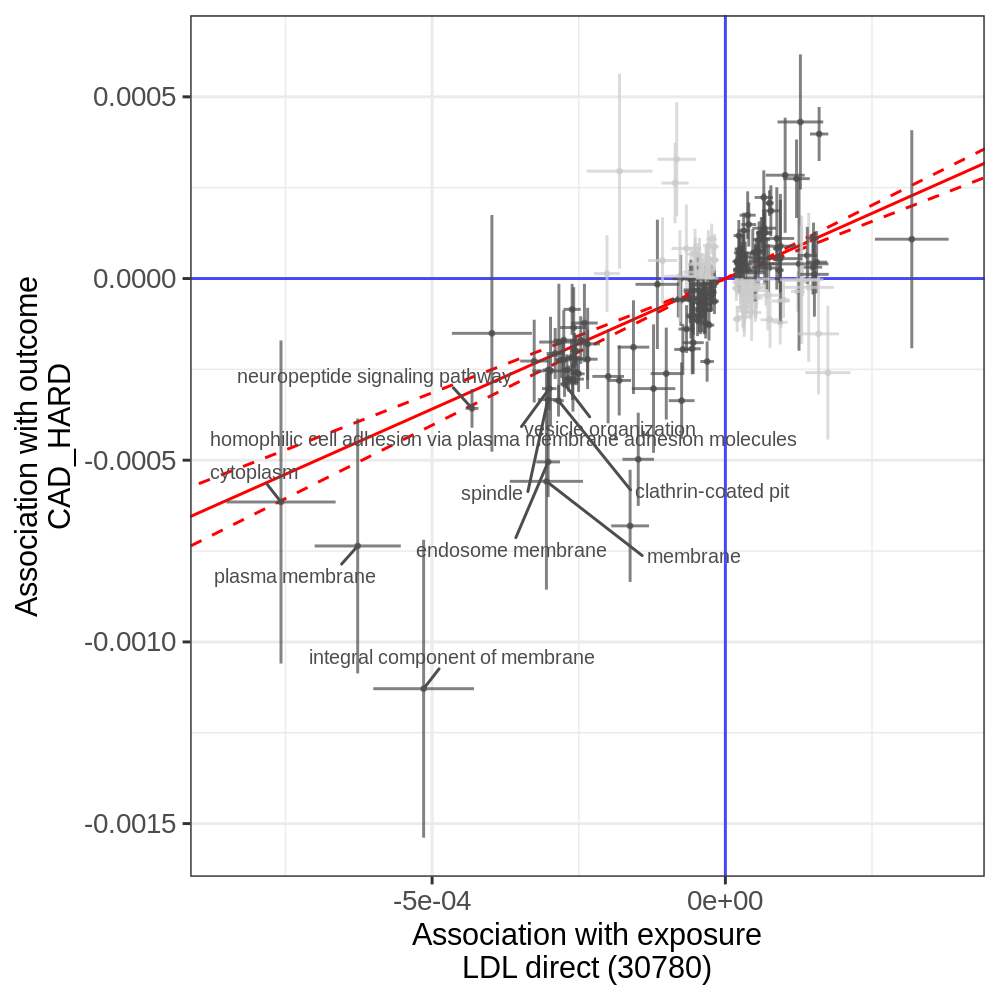

In [8]:
#############################################
### L pathways: LDL exposure, CAD outcome ###
#############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Liver'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/L_perc0.3_'
name_exposure <- '30780'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tot_path'
n_pl = 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name


### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 20, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)

pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

#tab_note <- cbind(tmp[, ], new)
new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome


new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]




[1] 9


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
10,239,272.8216,43.24676,188.0595,357.5837,2.817763e-10,337.9071,2.155418e-05,LDL direct (30780),30780,Blood_biochemistry,6.903519e-09


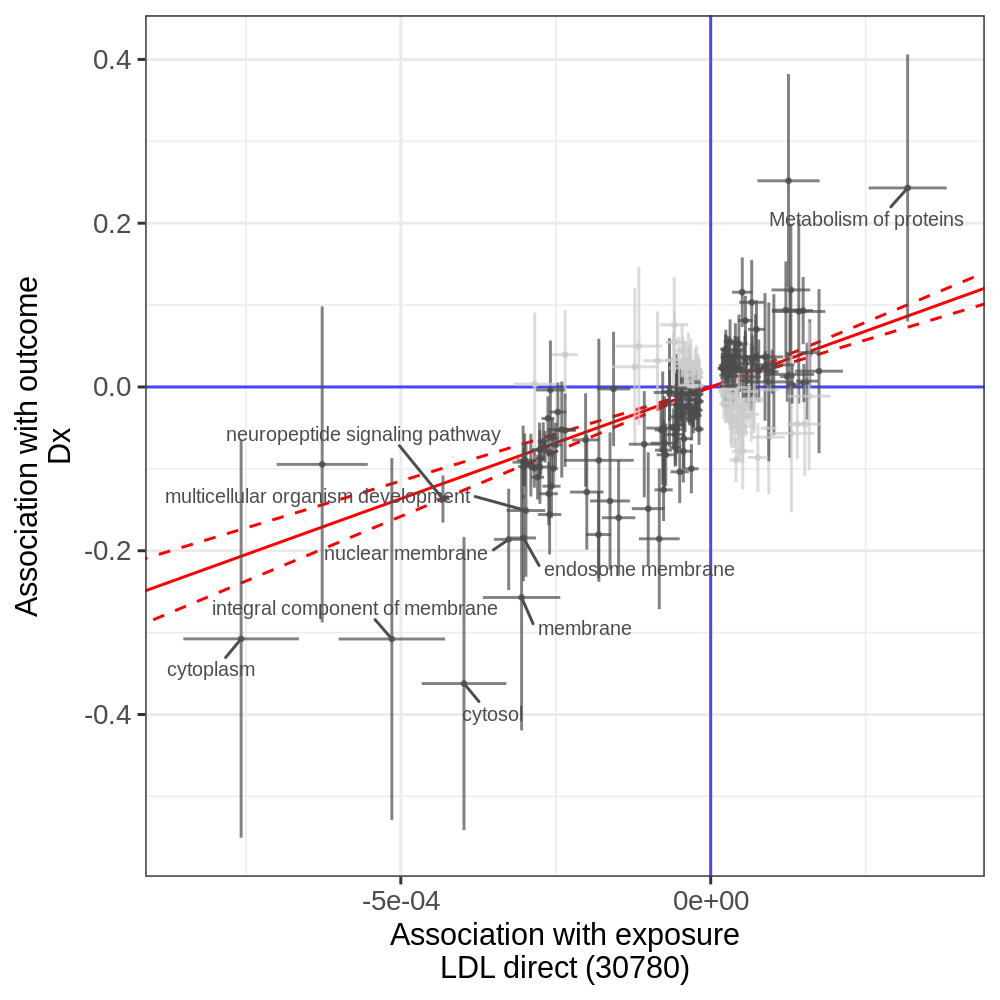

In [9]:
#############################################
### L pathways: LDL exposure, CAD outcome ###
############### CARDIoGRAM ##################
#############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Liver'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_L_perc0.3_'
name_exposure <- '30780'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tot_path'
n_pl = 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name


### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 20, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)

pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

#tab_note <- cbind(tmp[, ], new)
new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]



[1] 16


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
5,148,0.6019926,0.0914255,0.4228019,0.7811833,4.563728e-11,387.1752,1.615751e-23,LDL direct (30780),30780,Blood_biochemistry,5.202649e-10


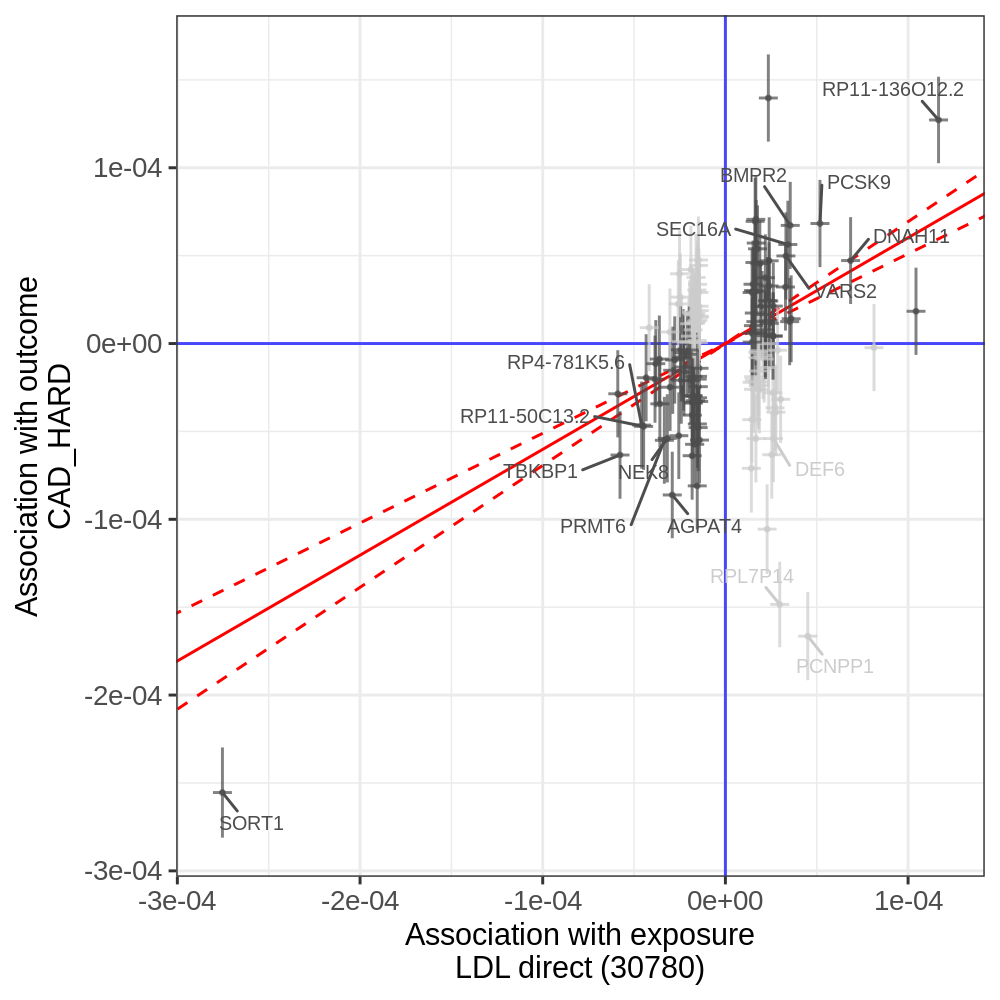

In [10]:
###########################################
### L tscore: LDL exposure, CAD outcome ###
###########################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Liver'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/L_dist200000b_'
name_exposure <- '30780'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tscore'
n_pl = 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]


[1] 14


,nfeat,MRIVW_est,MRIVW_est_se,MRIVW_est_CIl,MRIVW_est_CIu,MRIVW_est_pval,MRIVW_heter_stat,MRIVW_heter_pval,names_field,pheno,pheno_type,MRIVW_est_pval_FDR
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
3,138,218.5955,40.52542,139.1671,298.0238,6.889319e-08,246.0575,3.192028e-08,LDL direct (30780),30780,Blood_biochemistry,2.640906e-07


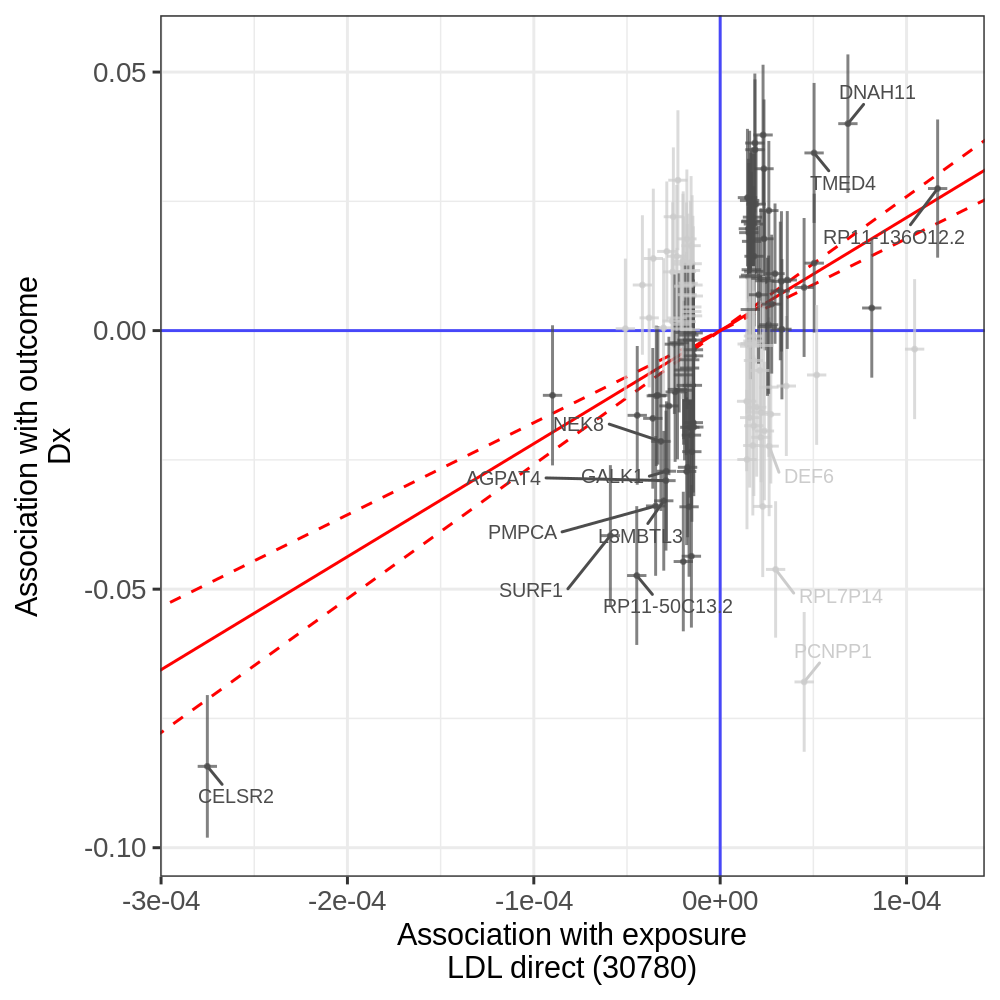

In [11]:
###########################################
### L tscore: LDL exposure, CAD outcome ###
############## CARDIoGRAM #################
###########################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Liver'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_L_dist200000b_'
name_exposure <- '30780'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_Blood_biochemistry_withMed_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tscore'
n_pl = 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
res$MR[res$MR$pheno == name_exposure, ]


[1] 30


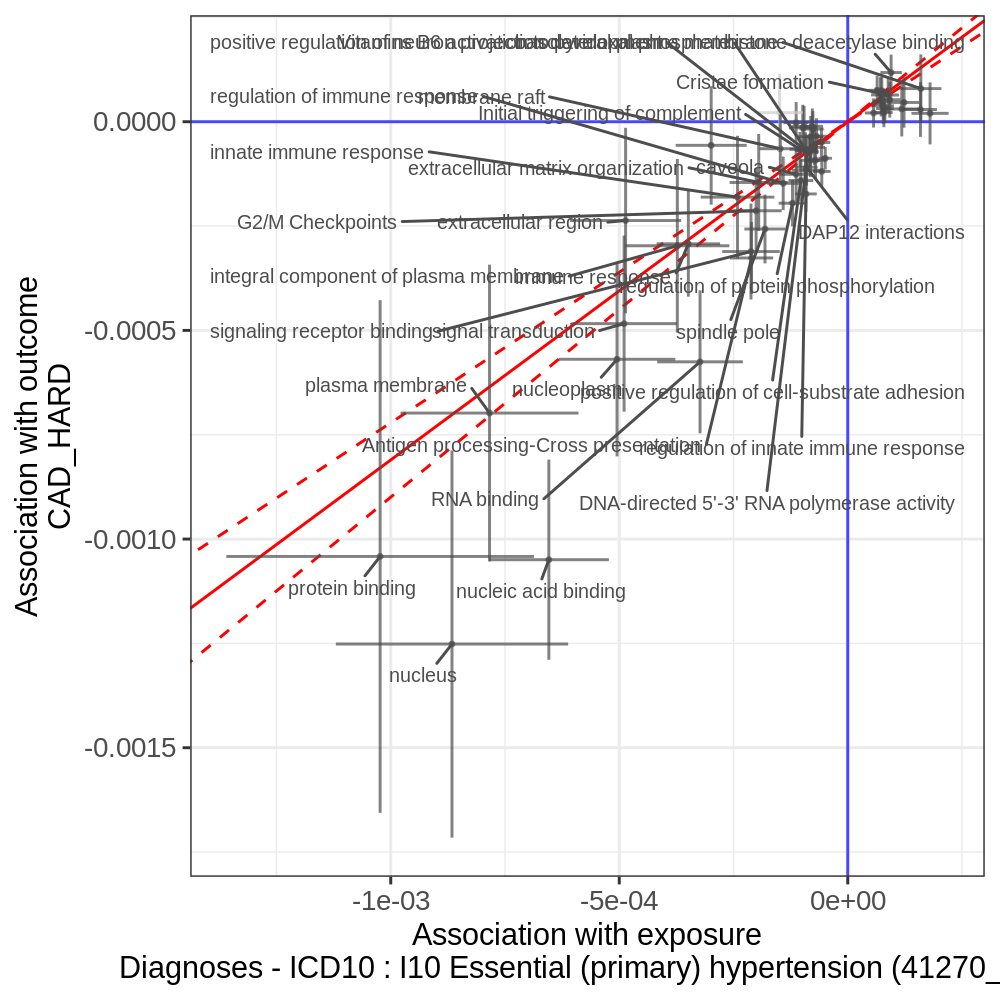

In [12]:
###########################################################
### AC pathways: I10 hypertension exposure, CAD outcome ###
###########################################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Artery_Coronary'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/AC_perc0.3_'
name_exposure <- '41270_I10'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_ICD10_Circulatory_system_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tot_path'
n_pl <- 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

#tab_note <- cbind(tmp[, ], new)
new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')




[1] 30


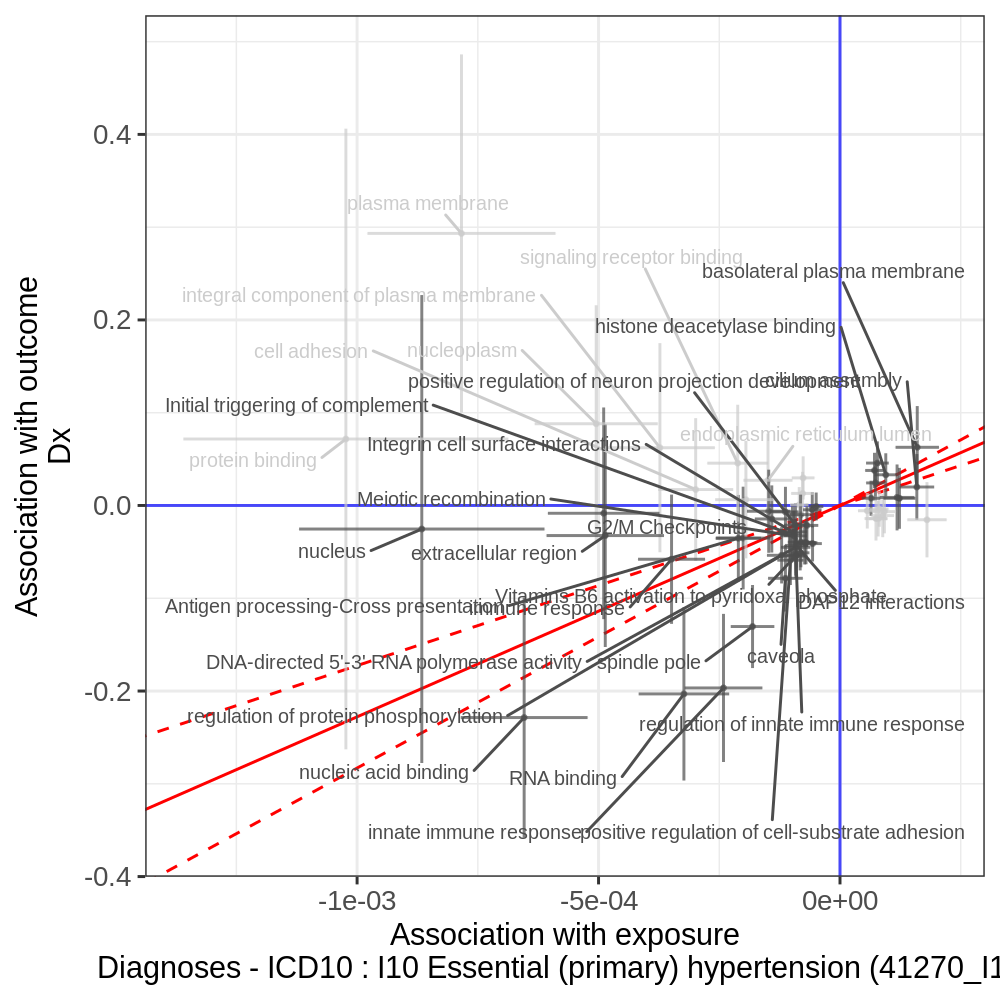

In [13]:
###########################################################
### AC pathways: I10 hypertension exposure, CAD outcome ###
###################### CARDIoGRAM #########################
###########################################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Artery_Coronary'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_Mendelian_randomization_IVW_tot_path_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
corrFeat_file <- sprintf('%scorrelation_estimate_tot_path.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_AC_perc0.3_'
name_exposure <- '41270_I10'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_ICD10_Circulatory_system_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tot_path'
n_pl <- 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

# get correlation matrix among pathways
corrFeat <- get(load(corrFeat_file))
new_id_R <- paste(res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'Reactome'], 'Reactome', sep = '_type_') 
tmp <- res$exposure[[1]]$path[res$exposure[[1]]$type %in% 'GO']
tmp_GO <- pathGO[pathGO$tissue == tissue, ]
new_id_GO <- paste(tmp_GO$path_id[match(tmp, tmp_GO$path)], 'GO', sep = '_type_') 
cor_filt <- corrFeat$cor[ c(new_id_R, new_id_GO), c(new_id_R, new_id_GO)]
new_name <- c(new_id_R, paste(tmp, 'GO',sep = '_type_'))
colnames(cor_filt) <- rownames(cor_filt) <- new_name

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)


pl_MR$pl[[1]]
# annotate table and save
new <- pl_MR$table[[1]]
tmp1 <- pathR[match(paste(new$name, tissue, sep = '_'), pathR$new_id), ]
tmp1 <- tmp1[!is.na(tmp1$path), ]
tmp2 <- pathGO[match(paste(new$name, tissue, sep = '_'), pathGO$new_id), ]
tmp2 <- tmp2[!is.na(tmp2$path), ]
if(nrow(tmp1)>0){tmp1$database  <- 'Reactome'}
if(nrow(tmp2)>0){tmp2$database  <- 'GO'}
if(nrow(tmp2)>0 & nrow(tmp1)>0){
    tmp <- rbind(tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')], 
                tmp2[, c('path', 'database','ngenes_tscore', 'ngenes_path', 'genes_path')])
}else{
    if(nrow(tmp1)>0){
       tmp <- tmp1[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }else{
       tmp <- tmp2[, c('path','database', 'ngenes_tscore', 'ngenes_path', 'genes_path')]
    }
}

#tab_note <- cbind(tmp[, ], new)
new <- cbind(new, tmp[match(new$name, tmp$path), -1])
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

new$new_id <- paste(new$path, new$database, sep = 'type')
# add class if they cluster together due to correlation:
new$new_id <- paste(new$name, new$database, sep = '_type_')
hc <- hclust(d = as.dist(1-abs(cor_filt[new$new_id, new$new_id])))
gr_path = cutree(hc, h = 0.8) # 0.8 corresponds to 0.2 correlation
new$class_path <- unname(gr_path)
new <- new[order(new$class_path), ]
new$class_path <- paste(new$class_path, tissue, name_exposure, name_outcome, sep = '_')
new <- new[, !colnames(new) %in% 'new_id']

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')


[1] 19


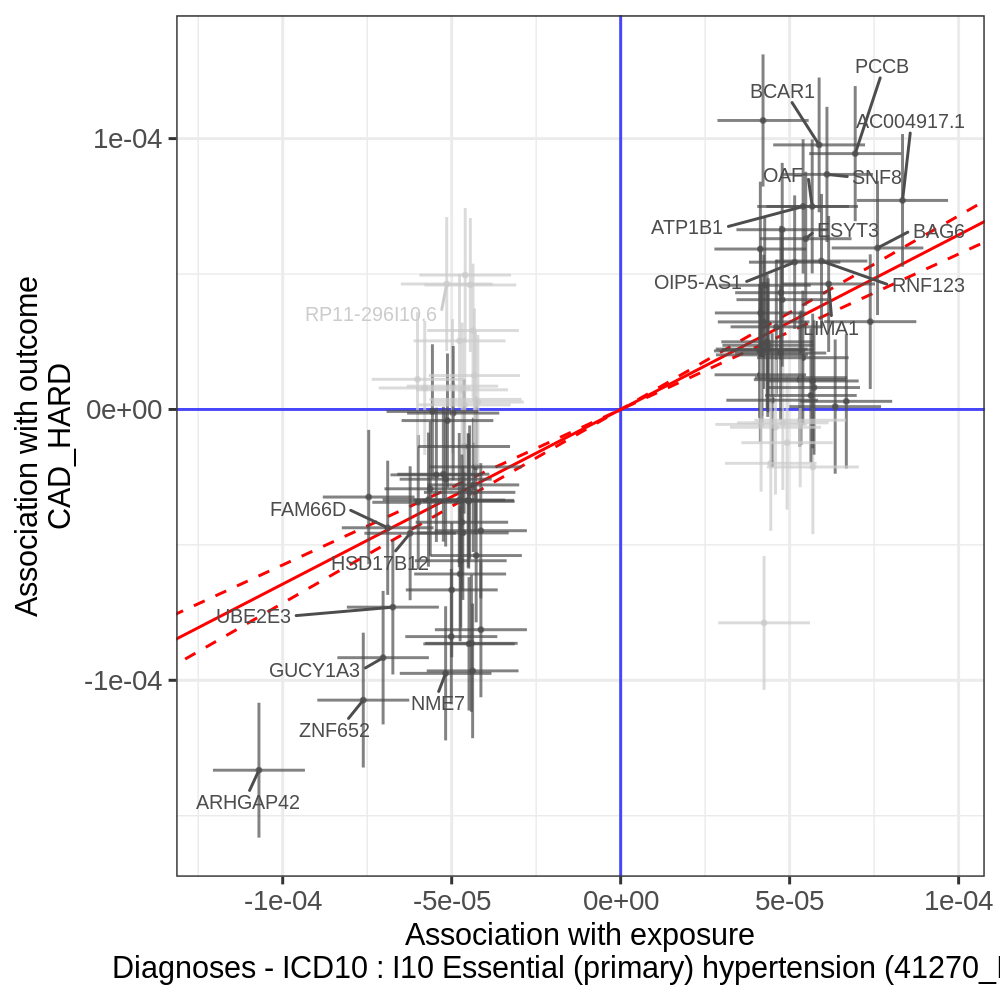

In [14]:
############################################
### AA tscore: I10 exposure, CAD outcome ###
############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Artery_Aorta'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/perc0.3_dist200000b_correlation_enrich_CAD_HARD_relatedPheno.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/AA_dist200000b_'
name_exposure <- '41270_I10'
name_outcome <- 'CAD_HARD' 
exposure_file <- sprintf('%s/pval_ICD10_Circulatory_system_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_CAD_pheno_covCorr.RData', fold)
type_data <- 'tscore'
n_pl = 40

### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)



pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')


[1] 23


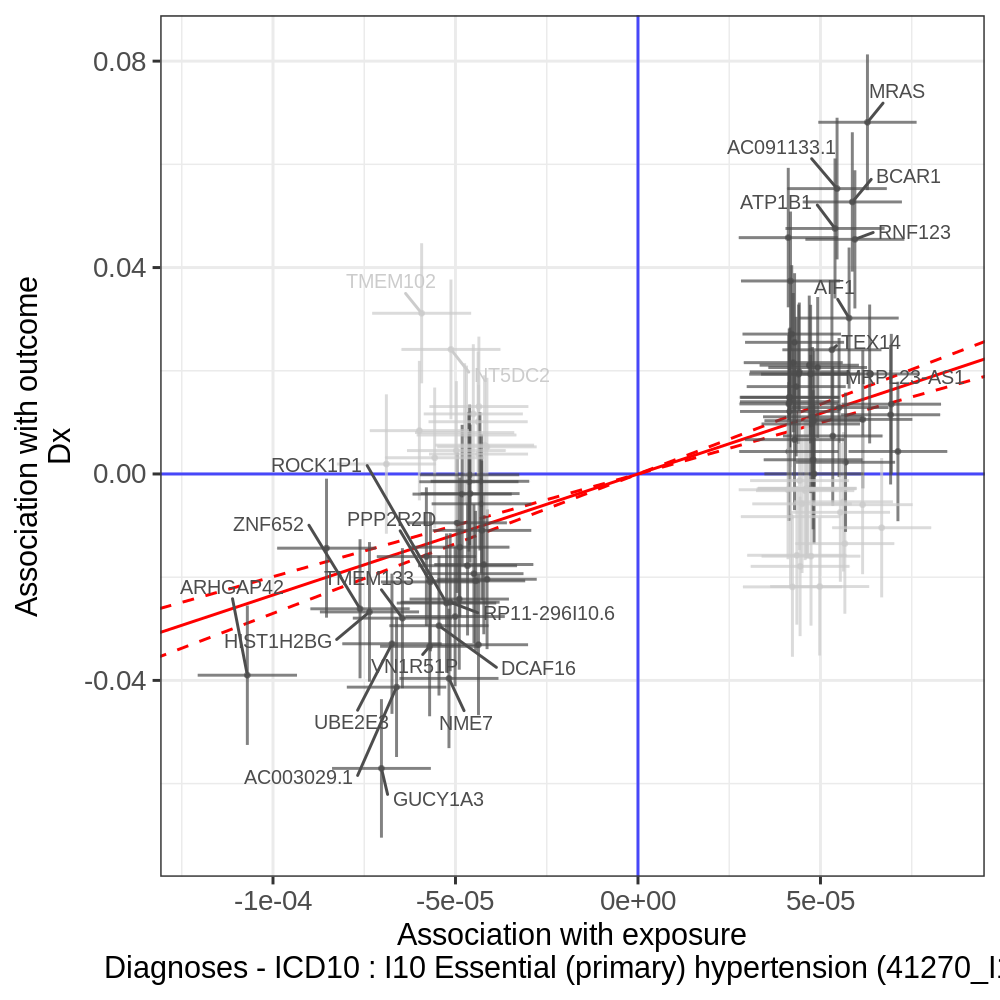

In [15]:
############################################
### AA tscore: I10 exposure, CAD outcome ###
############## CARDIoGRAM ##################
############################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

tissue <- 'Artery_Aorta'
fold <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/', 'CAD_UKBB/eQTL_PROJECT/',tissue)
fold_CardioG <- sprintf('%sOUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/','CAD_UKBB/eQTL_PROJECT/',tissue)
MRRes_IVW_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_dist200000b_Mendelian_randomization_IVW_tscore_pvalFDRrel0.05.txt', fold)
corrRes_file <- sprintf('%s/enrichment_CADHARD_res/CADCardioG_perc0.3_dist200000b_correlation_enrich_CADCardioG_relatedPheno.RData', fold)
outFold <- 'castom-igex_mr/Figures/CAD/CADCardioG_AA_dist200000b_'
name_exposure <- '41270_I10'
name_outcome <- 'Dx' 
exposure_file <- sprintf('%s/pval_ICD10_Circulatory_system_pheno_covCorr.RData', fold)
outcome_file  <- sprintf('%s/pval_Dx_pheno_covCorr.RData', fold_CardioG)
type_data <- 'tscore'
n_pl = 40
### load data ###
res <- get_coeff_out_exp(MRRes_IVW_file = MRRes_IVW_file, corrRes_file = corrRes_file, 
                  exposure_file = exposure_file, outcome_file = outcome_file, 
                  name_outcome = name_outcome, name_exposure = name_exposure, 
                  pval_FDR_rel = pval_FDR_rel, tissue = tissue)

### plot ###
pl_MR <- plot_MR_betas(MR_IVW_res = res$MR, res_pheno = res$exposure, res_out_red = res$output, 
                       name_outcome = name_outcome, name_exposure = name_exposure, outFold = outFold, 
                       type_data = type_data, n_pl = 40, name_id = res$name_id, id_beta = res$id_beta, plot_beta = T)

pl_MR$pl[[1]]

# annotate table and save
new <- pl_MR$table[[1]]
# load gene info
train_fold <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/', tissue)
tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold), h=T,stringsAsFactors = F, data.table = F)
tmp <- tmp[match(new$name, tmp$external_gene_name),]
new$chrom <- tmp$chrom
new$start_position <- tmp$start_position
new$end_position <- tmp$end_position
new$TSS_start <- tmp$TSS_start   
new$tissue <- tissue
new$exposure <- pl_MR$new_name
new$name_outcome <- name_outcome

write.table(x = new, file = sprintf('%sMR_%s_out%s_exp%s_intersectionBest%i.txt', outFold, type_data, name_outcome, name_exposure[1], n_pl), quote = F, row.names = F, col.names = T, sep = '\t')
